#Support Vector Machine (SVM)

In [1]:
# ==============================================================================
# CELL 1: SETUP AND FILE UPLOAD
# ==============================================================================
# Run this cell only once to import libraries and upload the dataset.

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC  # <-- Changed import for SVM
from sklearn.metrics import classification_report, accuracy_score
from google.colab import files

print("--- Step 1: Setup Complete ---")
print("Please upload your 'DailyDialog.csv' file.")

# This will open a file upload dialog in your browser.
uploaded = files.upload()

try:
    # Get the filename of the uploaded file
    filename = next(iter(uploaded))
    print(f"\nSuccessfully uploaded '{filename}'")
except StopIteration:
    print("\nNo file was uploaded. Please run this cell again to upload a file.")

--- Step 1: Setup Complete ---
Please upload your 'DailyDialog.csv' file.


Saving DailyDialog.csv to DailyDialog.csv

Successfully uploaded 'DailyDialog.csv'


In [26]:
# ==============================================================================
# CELL 2 (FINAL VERSION): LOAD, AUGMENT, AND PREPROCESS DATA
# ==============================================================================
# Run this cell to prepare the data for the model.

if 'filename' not in locals():
    print("File not uploaded yet. Please run Cell 1 first.")
else:
    print("--- Step 2: Loading and Preprocessing Data ---")
    df = pd.read_csv(filename)

    # --- Data Cleaning and Mapping ---
    df.dropna(subset=['text', 'sentiment'], inplace=True)

    sentiment_map = {
        'joy': 'positive', 'sadness': 'negative', 'anger': 'negative',
        'fear': 'negative', 'neutral': 'neutral'
    }
    df['sentiment_mapped'] = df['sentiment'].map(sentiment_map)
    df.dropna(subset=['sentiment_mapped'], inplace=True)

    # ==================== NEW SECTION: ADD YOUR OWN DATA! ====================
    print("\nAugmenting with custom data to make the model smarter...")
    # Add a variety of examples to fix misclassifications
    new_data = [
        # Positive Examples
        {"text": "I absolutely love this new restaurant", "sentiment_mapped": "positive"},
        {"text": "The service here is just amazing", "sentiment_mapped": "positive"},
        {"text": "This is the best food I have ever had", "sentiment_mapped": "positive"},
        {"text": "What a beautiful and sunny day", "sentiment_mapped": "positive"},

        # Negative Examples
        {"text": "I had a terrible experience at that place", "sentiment_mapped": "negative"},
        {"text": "The movie was a complete waste of time", "sentiment_mapped": "negative"},
        {"text": "I am very disappointed with the product", "sentiment_mapped": "negative"},

        # Neutral Examples (to fix the current issue)
        {"text": "My computer is on the desk in the office", "sentiment_mapped": "neutral"},
        {"text": "The car is parked in the garage", "sentiment_mapped": "neutral"},
        {"text": "She is reading a book in the library", "sentiment_mapped": "neutral"},
        {"text": "The meeting is scheduled for 3 PM", "sentiment_mapped": "neutral"},
        {"text": "He is wearing a blue shirt today", "sentiment_mapped": "neutral"}
    ]
    new_df = pd.DataFrame(new_data)

    # Combine the original DataFrame with your new data
    df = pd.concat([df, new_df], ignore_index=True)
    print(f"Added {len(new_data)} new rows. Total rows are now: {df.shape[0]}")
    # =========================================================================

    # --- Continue with text cleaning ---
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        return text

    df['text'] = df['text'].apply(clean_text)

    # --- Define Features (X) and Target (y) ---
    X = df['text']
    y = df['sentiment_mapped']

    print("\nData loading, augmenting, and preprocessing complete.")
    print("\nNew sentiment distribution:")
    print(y.value_counts())

--- Step 2: Loading and Preprocessing Data ---

Augmenting with custom data to make the model smarter...
Added 12 new rows. Total rows are now: 11339

Data loading, augmenting, and preprocessing complete.

New sentiment distribution:
sentiment_mapped
negative    6750
positive    2330
neutral     2259
Name: count, dtype: int64


In [27]:
# ==============================================================================
# CELL 3 (MODIFIED): TRAIN THE CALIBRATED SVM MODEL
# ==============================================================================
# Run this cell to split the data, vectorize it, and train the calibrated SVM.

# We need one more import for this cell
from sklearn.calibration import CalibratedClassifierCV

if 'X' not in locals() or 'y' not in locals():
    print("Data not preprocessed yet. Please run Cell 2 first.")
else:
    print("--- Step 3: Training the Calibrated SVM Model ---")
    # Split data into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize and fit the TF-IDF Vectorizer
    print("Vectorizing text data...")
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=5)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Initialize the base Linear SVM model
    base_svm = LinearSVC(random_state=42, max_iter=2000, dual=True)

    # Wrap the base SVM in a CalibratedClassifierCV to enable probability predictions
    print("Training the Calibrated SVM model...")
    svm_model = CalibratedClassifierCV(base_svm, cv=3) # 'cv=3' means 3-fold cross-validation
    svm_model.fit(X_train_tfidf, y_train)

    print("\nModel training complete.")

--- Step 3: Training the Calibrated SVM Model ---
Vectorizing text data...
Training the Calibrated SVM model...

Model training complete.


In [28]:
# ==============================================================================
# CELL 4: EVALUATE THE MODEL
# ==============================================================================
# Run this cell to evaluate the model's performance on the unseen test data.

if 'svm_model' not in locals():
    print("Model not trained yet. Please run Cell 3 first.")
else:
    print("--- Step 4: Evaluating the Model ---")
    # Make predictions on the test data
    y_pred = svm_model.predict(X_test_tfidf)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Print the detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

--- Step 4: Evaluating the Model ---

Overall Accuracy: 0.8073

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      1350
     neutral       0.72      0.71      0.71       452
    positive       0.77      0.61      0.68       466

    accuracy                           0.81      2268
   macro avg       0.78      0.74      0.76      2268
weighted avg       0.80      0.81      0.80      2268




Sentiment Analysis Prediction (SVM with Graph)
Enter a sentence to analyze its sentiment: Even though the project was incredibly difficult, I'm proud of the final result.

Sentence: 'Even though the project was incredibly difficult, I'm proud of the final result.'
Predicted Sentiment: -> NEGATIVE <-


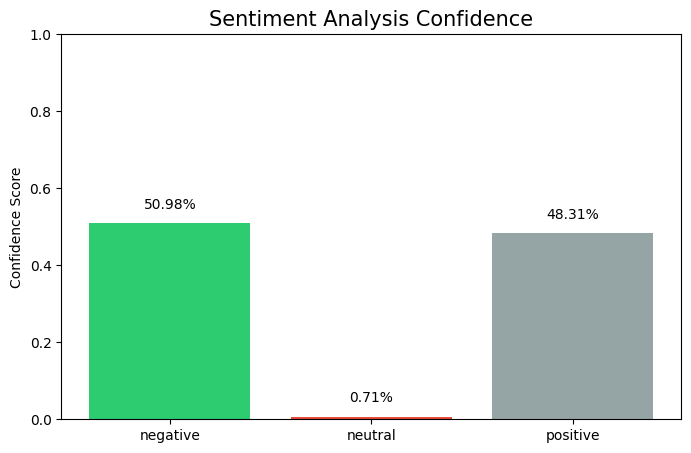

In [39]:
# ==============================================================================
# CELL 5: PREDICT SENTIMENT AND GENERATE A VISUAL GRAPH
# ==============================================================================
# Run this cell to test the trained model and see a graph of the confidence scores.

# We need matplotlib to create the graph
import matplotlib.pyplot as plt

if 'svm_model' not in locals():
    print("Model not trained yet. Please run the MODIFIED Cell 3 first.")
else:
    print("\n" + "="*50)
    print("Sentiment Analysis Prediction (SVM with Graph)")
    print("="*50)

    # Get user input
    user_sentence = input("Enter a sentence to analyze its sentiment: ")

    # Clean and vectorize the sentence
    cleaned_sentence = clean_text(user_sentence)
    vectorized_sentence = tfidf_vectorizer.transform([cleaned_sentence])

    # Predict the sentiment using the trained SVM model
    prediction = svm_model.predict(vectorized_sentence)

    # Get the probability scores for each class
    probabilities = svm_model.predict_proba(vectorized_sentence)
    sentiment_classes = svm_model.classes_

    print(f"\nSentence: '{user_sentence}'")
    print(f"Predicted Sentiment: -> {prediction[0].upper()} <-")

    # --- Generate the Bar Chart ---

    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 5))

    # Create the bar plot
    bars = ax.bar(sentiment_classes, probabilities[0], color=['#2ecc71', '#e74c3c', '#95a5a6'])

    # Add labels and title
    ax.set_ylabel('Confidence Score')
    ax.set_title('Sentiment Analysis Confidence', fontsize=15)
    ax.set_ylim(0, 1) # Set y-axis limit from 0 to 1 (for probabilities)

    # Add the confidence score text on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.03, f'{yval*100:.2f}%', ha='center', va='bottom')

    # Display the plot
    plt.show()

    print("="*50)